In [ ]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import *

from matplotlib.pyplot import imshow

2.7.17


In [2]:
from google.colab import files

In [3]:
from google.colab import drive  # not necessary

In [20]:
# set the name of the folder to download images
img_folder_nm = 'quiz_file'  # 이 이름은 바꿔도 됨

# set the name of the zip file to be downloaded
img_zipfile_nm = 'sample_labeled.zip' # 올린 파일의 이름으로 고정 -> 압축파일 이름이 다르면 바꿔줘야 함

In [21]:
!ls

quiz1  sample_data  sample_labeled.zip


In [22]:
%%capture

!unzip {img_zipfile_nm} -d {img_folder_nm}

In [23]:
!ls {img_folder_nm}

__MACOSX  sample_labeled


In [24]:
# location of images
path = Path(img_folder_nm)

# get list of image files
file_names = get_image_files(path)
file_names

# (#1500) -> 파일이 1500개가 있음을 의미

(#196) [Path('quiz_file/sample_labeled/land/3014.png'),Path('quiz_file/sample_labeled/land/4150.png'),Path('quiz_file/sample_labeled/land/1847.png'),Path('quiz_file/sample_labeled/land/4274.png'),Path('quiz_file/sample_labeled/land/4222.png'),Path('quiz_file/sample_labeled/land/1813.png'),Path('quiz_file/sample_labeled/land/2429.png'),Path('quiz_file/sample_labeled/land/5999.png'),Path('quiz_file/sample_labeled/land/1724.png'),Path('quiz_file/sample_labeled/land/6125.png')...]

(276, 276)


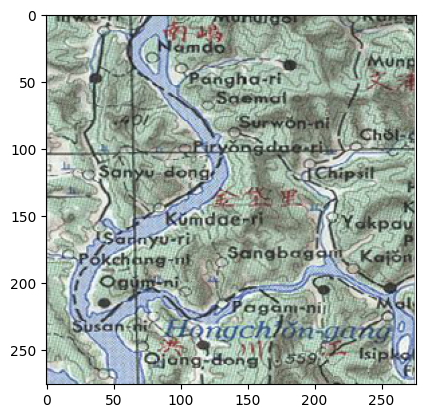

In [25]:
# show an example image

im = Image.open(file_names[0])
print(im.shape)
imshow(im)

In [26]:
# find corrupt images and unlink them

corrupt_images = verify_images(file_names)

corrupt_images.map(Path.unlink);

corrupt_images

(#0) []

In [27]:
# data block settings

image_size = 276  # 모델에 넣을 때 균일한 이미지 사이즈로 맞추기
valid_set_share = 0.3  # validation set을 얼마나 가져갈지    퀴즈 가능!
my_random_seed = 42

my_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=valid_set_share, seed=my_random_seed),
    get_y=parent_label,  # 폴더 이름으로 이미지의 정답값을 tagging
    item_tfms=Resize(image_size))

In [28]:
# prepare dataloaders

dls = my_dblock.dataloaders(path)  #train, validation dataset이 있음

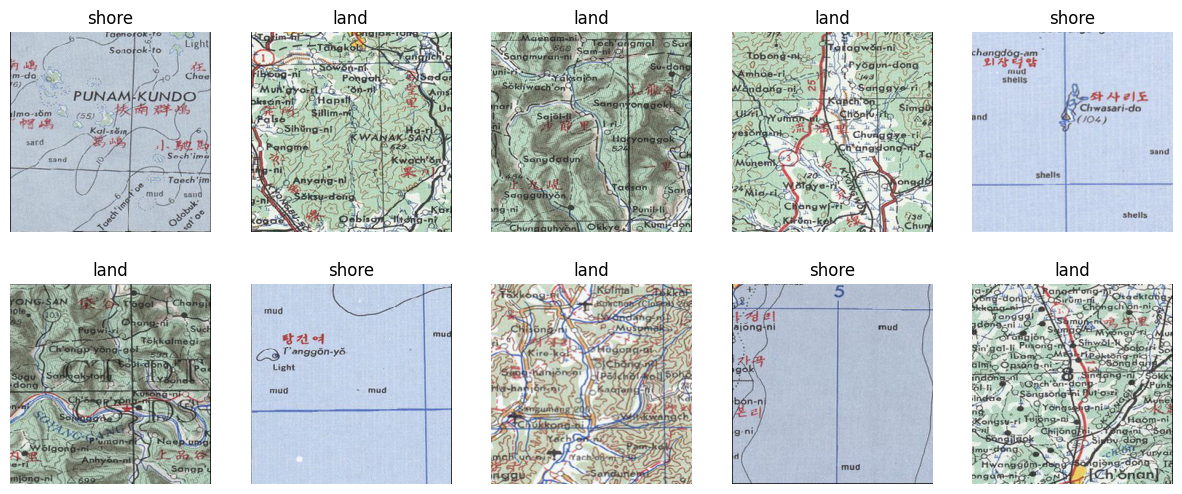

In [29]:
# show image examples

dls.train.show_batch(max_n=10, nrows=2)  # train dataset의 예시 batch 출력 -> 이미지 크기 동일!

# 모델 설정

In [31]:
learn = vision_learner(dls, resnet34, metrics=accuracy).to_fp16() # resnet 34
learn.path = Path('./')

# 100 epochs, 10 patience, validation accuracy
learn.fine_tune(100, cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10),SaveModelCallback(monitor='accuracy')])


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,1.160872,0.340602,0.827586,00:03


Better model found at epoch 0 with accuracy value: 0.8275862336158752.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.633622,0.431503,0.810345,00:02
1,0.537080,0.505873,0.775862,00:01
2,0.447237,0.476019,0.810345,00:01
3,0.380910,0.403235,0.862069,00:01
4,0.333974,0.332011,0.896552,00:01
5,0.297105,0.295012,0.913793,00:01
6,0.256151,0.275765,0.948276,00:02
7,0.226613,0.259417,0.965517,00:01
8,0.202174,0.257897,0.965517,00:01
9,0.180704,0.254964,0.965517,00:02


Better model found at epoch 0 with accuracy value: 0.8103448152542114.
Better model found at epoch 3 with accuracy value: 0.8620689511299133.
Better model found at epoch 4 with accuracy value: 0.8965517282485962.
Better model found at epoch 5 with accuracy value: 0.9137930870056152.
Better model found at epoch 6 with accuracy value: 0.9482758641242981.
Better model found at epoch 7 with accuracy value: 0.9655172228813171.
Better model found at epoch 13 with accuracy value: 0.982758641242981.
No improvement since epoch 13: early stopping


# Confusion Matrix

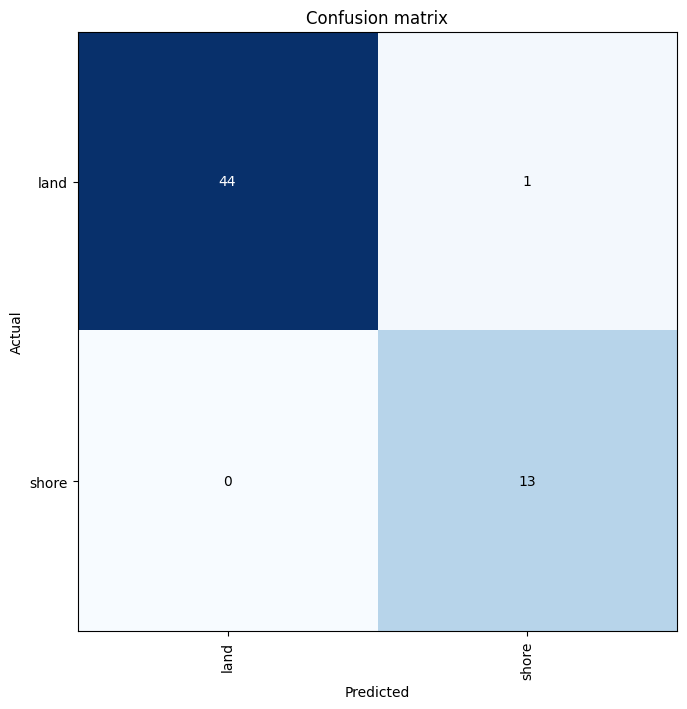

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))  # regular confusion matrix

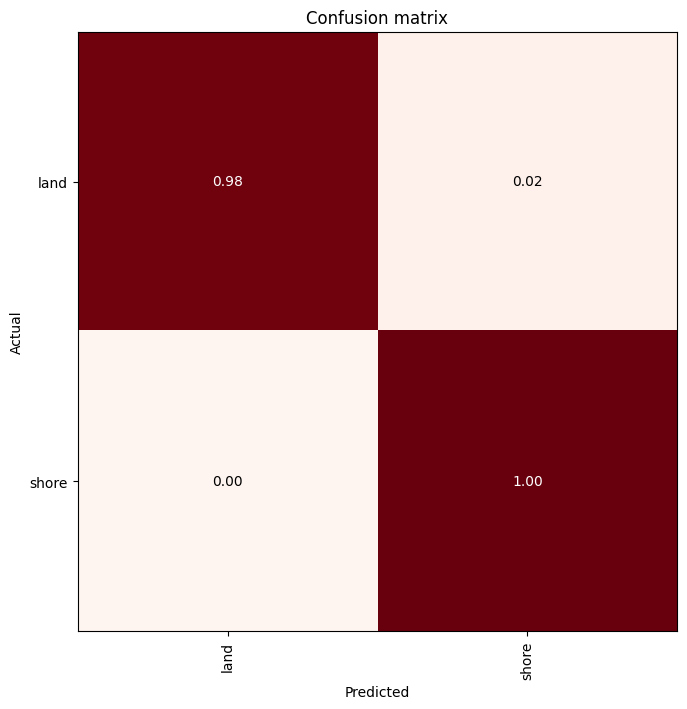

In [33]:
interp.plot_confusion_matrix(normalize=True, cmap='Reds', figsize=(7,7))  # normalized confusion matrix

In [34]:
# export your model
learn.export()

In [35]:
!ls

export.pkl  models  quiz1  quiz_file  sample_data  sample_labeled.zip  test_30.zip


# 학습된 모델로 test 이미지 예측 후 결과 테이블 만들기

In [36]:
model_nm = 'export.pkl'

In [37]:
!ls -l

total 131964
-rw-r--r-- 1 root root 87470829 Sep 26 02:00 export.pkl
drwxr-xr-x 2 root root     4096 Sep 26 01:57 models
drwxr-xr-x 4 root root    12288 Sep 26 01:49 quiz1
drwxr-xr-x 4 root root     4096 Sep 26 01:54 quiz_file
drwxr-xr-x 1 root root     4096 Sep 24 13:23 sample_data
-rw-r--r-- 1 root root 41448319 Sep 26 01:49 sample_labeled.zip
-rw-r--r-- 1 root root  6178108 Sep 26 01:59 test_30.zip


In [38]:
!zip -T export.pkl

test of export.pkl OK


In [39]:
# load your saved model
#learn_inf = load_learner(model_nm)
learn_inf = load_learner(model_nm)

In [40]:
### download images for predictions

# set the name of the folder to download images
img_folder_nm = 'new_images_for_prediction'

# set the name of the zip file to be downloaded
img_zipfile_nm = 'test_30.zip'


In [41]:
%%capture
!unzip {img_zipfile_nm} -d {img_folder_nm}  #__MACOSX 폴더가 자동으로 생성되는데, 이 파일 때문에 오류 날 수 있음

In [42]:
# grab a list of images in the folder

test_imgs_list = get_image_files(img_folder_nm)
test_imgs_list

(#30) [Path('new_images_for_prediction/513.png'),Path('new_images_for_prediction/3058.png'),Path('new_images_for_prediction/2463.png'),Path('new_images_for_prediction/1892.png'),Path('new_images_for_prediction/4609.png'),Path('new_images_for_prediction/4204.png'),Path('new_images_for_prediction/5461.png'),Path('new_images_for_prediction/2041.png'),Path('new_images_for_prediction/736.png'),Path('new_images_for_prediction/3812.png')...]

# Prediction

In [43]:
# predict single image
print('- file for prediction: {}'.format(test_imgs_list[0]))
print('')
print('- prediction result:')

single_pred = learn_inf.predict(test_imgs_list[0])
single_pred

- file for prediction: new_images_for_prediction/513.png

- prediction result:


('shore', tensor(1), tensor([2.1577e-14, 1.0000e+00]))

In [44]:
# generate predictions for multiple images

new_predictions = []
new_predictions_label_only = []
new_predictions_proba_only = []

for each_img in test_imgs_list:
    each_pred = learn_inf.predict(each_img)
    new_predictions.append(each_pred)
    new_predictions_label_only.append(each_pred[0])

In [45]:
new_predictions

[('shore', tensor(1), tensor([2.1577e-14, 1.0000e+00])),
 ('shore', tensor(1), tensor([6.0357e-10, 1.0000e+00])),
 ('land', tensor(0), tensor([9.9997e-01, 3.0787e-05])),
 ('land', tensor(0), tensor([0.7292, 0.2708])),
 ('land', tensor(0), tensor([9.9921e-01, 7.9026e-04])),
 ('land', tensor(0), tensor([0.9379, 0.0621])),
 ('shore', tensor(1), tensor([0.0453, 0.9547])),
 ('land', tensor(0), tensor([0.9979, 0.0021])),
 ('land', tensor(0), tensor([0.6237, 0.3763])),
 ('land', tensor(0), tensor([9.9971e-01, 2.9363e-04])),
 ('shore', tensor(1), tensor([3.4268e-14, 1.0000e+00])),
 ('shore', tensor(1), tensor([5.7213e-14, 1.0000e+00])),
 ('land', tensor(0), tensor([0.9919, 0.0081])),
 ('land', tensor(0), tensor([0.5779, 0.4221])),
 ('land', tensor(0), tensor([9.9997e-01, 2.7367e-05])),
 ('land', tensor(0), tensor([0.7644, 0.2356])),
 ('shore', tensor(1), tensor([2.8287e-10, 1.0000e+00])),
 ('land', tensor(0), tensor([9.9989e-01, 1.1195e-04])),
 ('land', tensor(0), tensor([9.9902e-01, 9.7533e-0

In [46]:
# get lables
new_predictions_label_only

['shore',
 'shore',
 'land',
 'land',
 'land',
 'land',
 'shore',
 'land',
 'land',
 'land',
 'shore',
 'shore',
 'land',
 'land',
 'land',
 'land',
 'shore',
 'land',
 'land',
 'shore',
 'land',
 'land',
 'shore',
 'land',
 'land',
 'land',
 'land',
 'land',
 'land',
 'shore']

In [47]:
# create a table for predictions

final_table = pd.DataFrame(zip(test_imgs_list, new_predictions_label_only), columns=['file_path', 'label'])
final_table

,file_path,label
0,new_images_for_prediction/513.png,shore
1,new_images_for_prediction/3058.png,shore
2,new_images_for_prediction/2463.png,land
3,new_images_for_prediction/1892.png,land
4,new_images_for_prediction/4609.png,land
5,new_images_for_prediction/4204.png,land
6,new_images_for_prediction/5461.png,shore
7,new_images_for_prediction/2041.png,land
8,new_images_for_prediction/736.png,land
9,new_images_for_prediction/3812.png,land


In [48]:
# export as an excel file
final_table.to_excel('final_table.xlsx', index=False)